In [1]:
%load_ext autoreload
%autoreload 2

#<font color='orange'>Basics</font>

In [1]:
#@title **Location** of the dataset
path =  "../data/LendingClub/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"
backup_image_folder = "../../backup/Images/"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import os
import re



from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [3]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [5]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri
import credit_pipeline.evaluate as ev

from submodules.topsis_python import topsis as top

[x] add kfold

[x] add topsis/ahp multicriterio

[x] add criterio de parada

[-] pip freeze

#Read Dataset

In [6]:
ls '../data/LendingClub/'

accepted_2007_to_2018Q4.csv  rejected_2007_to_2018Q4.csv


In [7]:
#Accepts

la = ["issue_d", "loan_amnt", "funded_amnt", "funded_amnt_inv", "term", "int_rate"]
lb = ["installment", "emp_length", "annual_inc", "verification_status", "loan_status", 
      "purpose", "addr_state", "dti", "delinq_2yrs"]
lc = ["inq_last_6mths", "open_acc", "home_ownership", "revol_bal", "revol_util",
       "total_acc", "total_pymnt", "total_rec_prncp", "total_rec_int", "total_pymnt_inv",
         "last_pymnt_amnt", "last_fico_range_high", "last_fico_range_low"]

selected_columns_a = la+lb+lc

# Define the chunk size for reading the CSV file
chunksize = 100000  # Adjust this value based on your requirements

# Initialize an empty list to store filtered chunks
filtered_chunks = []

# Read the CSV file in chunks based on the defined chunk size
for chunk in pd.read_csv(path+'accepted_2007_to_2018Q4.csv', chunksize=chunksize, usecols=selected_columns_a):
    # Filter the current chunk based on the criteria
    filtered_chunk = chunk[chunk['issue_d'].str.contains("2009", na=False)]
    # filtered_chunk = filtered_chunk[~filtered_chunk['issue_d'].str.contains("Oct-2013|Nov-2013|Dec-2013", na=False)]
    # Append the filtered chunk to the list
    filtered_chunks.append(filtered_chunk)

# Concatenate all filtered chunks into a single DataFrame
df_a = pd.concat(filtered_chunks)

# Now filtered_df contains only the rows that match the specified criteria
# print(df_a.issue_d.unique())
df_a


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,last_fico_range_high,last_fico_range_low
1645106,1000.0,1000.0,1000.000000,36 months,7.40,31.06,1 year,MORTGAGE,107000.0,Not Verified,...,4938.0,1.9,35.0,1006.220000,1006.22,1000.00,6.22,1006.28,774.0,770.0
1645112,7500.0,7500.0,7350.000000,36 months,7.05,231.75,1 year,RENT,12720.0,Not Verified,...,0.0,0.0,9.0,2073.270000,2031.77,1547.57,248.18,13.00,619.0,615.0
1645113,8700.0,8700.0,8550.000000,36 months,7.05,268.83,2 years,MORTGAGE,54000.0,Not Verified,...,3519.0,11.3,15.0,9538.399493,9373.95,8700.00,838.40,3633.76,799.0,795.0
1645118,7000.0,7000.0,6953.550000,36 months,12.18,233.10,4 years,RENT,30000.0,Not Verified,...,6601.0,58.2,15.0,1668.720000,1661.80,995.51,400.51,233.10,539.0,535.0
1645119,9000.0,9000.0,8850.000000,36 months,7.05,278.10,9 years,RENT,130000.0,Not Verified,...,4433.0,3.9,28.0,9768.408834,9605.60,9000.00,768.41,271.03,814.0,810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653227,15000.0,15000.0,11933.870000,36 months,11.89,497.46,9 years,MORTGAGE,90000.0,Verified,...,96473.0,48.1,23.0,17694.467802,13860.79,14999.99,2694.48,4776.14,749.0,745.0
1653228,15000.0,15000.0,7155.150000,36 months,16.63,532.05,10+ years,MORTGAGE,114000.0,Verified,...,107611.0,89.1,19.0,4095.940000,2126.30,1322.86,803.82,532.05,759.0,755.0
1653229,5000.0,5000.0,2675.000000,36 months,13.47,169.62,< 1 year,OTHER,12000.0,Not Verified,...,2905.0,25.5,10.0,1880.820000,1005.25,1318.37,544.29,184.62,564.0,560.0
1653231,9000.0,9000.0,5560.850626,36 months,8.00,282.03,5 years,MORTGAGE,100000.0,Verified,...,212878.0,5.8,26.0,10152.886036,6188.31,8999.99,1152.89,293.81,739.0,735.0


In [8]:
#Rejects
selected_columns_r = ["Application Date", "Debt-To-Income Ratio","State", "Risk_Score", "Amount Requested", "Employment Length"]

# Define the chunk size for reading the CSV file
chunksize = 100000  # Adjust this value based on your requirements

# Initialize an empty list to store filtered chunks
filtered_chunks = []

# Read the CSV file in chunks based on the defined chunk size
for chunk in pd.read_csv(path+'rejected_2007_to_2018Q4.csv', chunksize=chunksize, usecols=selected_columns_r):
    # Filter the current chunk based on the criteria
    chunk["Application Date"] = chunk["Application Date"].astype(str)
    filtered_chunk = chunk[chunk["Application Date"].str.contains("2009", na=False)]
    # filtered_chunk = filtered_chunk[~filtered_chunk["Application Date"].str.contains("2013-10|2013-11|2013-12", na=False)]
    # Append the filtered chunk to the list
    filtered_chunks.append(filtered_chunk)

# Concatenate all filtered chunks into a single DataFrame
df_r = pd.concat(filtered_chunks)

# Now filtered_df contains only the rows that match the specified criteria
df_r

,Amount Requested,Application Date,Risk_Score,Debt-To-Income Ratio,State,Employment Length
30870,9000.0,2009-01-01,517.0,0.51%,MA,3 years
30871,12000.0,2009-01-01,646.0,10.22%,RI,1 year
30872,10000.0,2009-01-01,NaN,-1%,HI,10+ years
30873,15000.0,2009-01-01,556.0,7.07%,FL,10+ years
30874,5000.0,2009-01-01,546.0,12.26%,PA,9 years
...,...,...,...,...,...,...
87856,1000.0,2009-12-31,679.0,43.8%,IL,< 1 year
87857,10000.0,2009-12-31,631.0,9.78%,IL,1 year
87858,7500.0,2009-12-31,646.0,6.66%,CA,3 years
87859,10000.0,2009-12-31,556.0,2.55%,NH,< 1 year


In [9]:
# df_a_B, df_r_B = df_a.copy(), df_r.copy()
# df_a, df_r = df_a_B.copy(), df_r_B.copy() 

In [10]:
dex.get_shapes(df_a, df_r)

__ : (5281, 28)
_ : (56991, 6)


In [11]:
#rejected fix names
df_r["emp_length"] = df_r["Employment Length"]
df_r["addr_state"] = df_r["State"]
df_r["dti"] = df_r["Debt-To-Income Ratio"]
df_r["dti"] = pd.to_numeric(df_r['dti'].str.replace('%', ''))
df_r["loan_amnt"] = df_r["Amount Requested"]
df_r["risk_score"] = df_r["Risk_Score"]

#accepted fix names
df_a["risk_score"] = df_a.loc[:,["last_fico_range_high","last_fico_range_low"]].mean(axis=1)
df_a["target"] = np.where((df_a.loan_status == 'Current') |
                        (df_a.loan_status == 'Fully Paid') |
                        (df_a.loan_status== "Issued") |
                        (df_a.loan_status == 'Does not meet the credit policy. Status:Fully Paid'), 0, 1)


In [12]:
#columns based on Shih et al. (2022)
pearson_a = ['int_rate', 'dti', 'delinq_2yrs', 
 'home_ownership','revol_util','total_rec_prncp', 'total_rec_int', 'risk_score', 'target']
pearson_r = ['dti', 'risk_score']

df_a = df_a.loc[:, pearson_a]
df_r = df_r.loc[:, pearson_r]


In [13]:
# df_a = df_a.drop(columns=["loan_status", "last_fico_range_low", "last_fico_range_high", "issue_d"])
# df_r = df_r.drop(columns=["Amount Requested", "Employment Length", "State",
#                    "Debt-To-Income Ratio", "Amount Requested","Risk_Score", "Application Date"])

In [14]:
#rearrange columns order in df_a to match df_r

new_column_order = list(df_r.columns)

# Extend with any columns from df_a that aren't in df_r
new_column_order += list(df_a.columns.difference(df_r.columns))
new_column_order.remove('target')
new_column_order.append('target')

df_a = df_a.reindex(columns=new_column_order)

In [15]:
# #Fix dtype of variable emp_length (Object -> number)
try:
    df_a['emp_length'] = df_a['emp_length'].map(lambda x: "0" if x == '< 1 year' else x)
    df_a['emp_length'] = df_a['emp_length'].map(lambda x : int(re.search(r'\d+', x).group()), na_action='ignore')

    df_r['emp_length'] = df_r['emp_length'].map(lambda x: "0" if x == '< 1 year' else x)
    df_r['emp_length'] = df_r['emp_length'].map(lambda x : int(re.search(r'\d+', x).group()), na_action='ignore')
except Exception as e:
    print(e)

try:
    df_a['term'] = df_a['term'].map(lambda x : int(re.search(r'\d+', x).group()))
except Exception as e:
    print(e)

'emp_length'
'term'


In [16]:
# df_a_B, df_r_B = df_a.copy(), df_r.copy()
# df_a, df_r = df_a_B.copy(), df_r_B.copy() 

In [17]:
#add missing columns to df_r
input_columns = df_a.columns.difference(df_r.columns).to_list()
input_columns.remove('target')

for col in input_columns:
    df_r.insert(df_r.columns.shape[0], col, np.nan)

In [18]:
df_r

,dti,risk_score,delinq_2yrs,home_ownership,int_rate,revol_util,total_rec_int,total_rec_prncp
30870,0.51,517.0,NaN,NaN,NaN,NaN,NaN,NaN
30871,10.22,646.0,NaN,NaN,NaN,NaN,NaN,NaN
30872,-1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30873,7.07,556.0,NaN,NaN,NaN,NaN,NaN,NaN
30874,12.26,546.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
87856,43.80,679.0,NaN,NaN,NaN,NaN,NaN,NaN
87857,9.78,631.0,NaN,NaN,NaN,NaN,NaN,NaN
87858,6.66,646.0,NaN,NaN,NaN,NaN,NaN,NaN
87859,2.55,556.0,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
dex.get_shapes(df_a, df_r)

df_a : (5281, 9)
_ : (56991, 8)


In [20]:
#@title Create develoment train and test
# df_train, df_test = tr.create_train_test(df_o, seed=43)

In [21]:
#@title Set seed
new_seed = False #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000) #to name the results files

    while seed_number <100:
        seed_number = secrets.randbelow(1_000)
else:
    seed_number = 42000

main_seed = seed_number
print(seed_number)

42000


#Params

In [22]:
params_dict = ri.params_dict

In [23]:
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
              'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
              'learning_rate': 0.052227873762946964, 'max_depth': 5,
              'min_child_samples': 26, 'min_child_weight': 0.001,
              'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
              'num_leaves': 12, 'objective': None, 'random_state': seed_number,
              'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
              'subsample_for_bin': 200000, 'subsample_freq': 0,
              'is_unbalance': True}

params_dict['RandomForest_1'] = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None,
                        'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2',
                        'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0,
                        'min_samples_leaf': 9, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0,
                        'n_estimators': 173, 'n_jobs': -1, 'oob_score': False, 'random_state': seed_number,
                        'verbose': 0, 'warm_start': False},

In [24]:
df_a

,dti,risk_score,delinq_2yrs,home_ownership,int_rate,revol_util,total_rec_int,total_rec_prncp,target
1645106,0.96,772.0,0.0,MORTGAGE,7.40,1.9,6.22,1000.00,0
1645112,0.00,617.0,0.0,RENT,7.05,0.0,248.18,1547.57,1
1645113,2.67,797.0,0.0,MORTGAGE,7.05,11.3,838.40,8700.00,0
1645118,19.36,537.0,0.0,RENT,12.18,58.2,400.51,995.51,1
1645119,4.98,812.0,0.0,RENT,7.05,3.9,768.41,9000.00,0
...,...,...,...,...,...,...,...,...,...
1653227,17.11,747.0,0.0,MORTGAGE,11.89,48.1,2694.48,14999.99,0
1653228,21.95,757.0,0.0,MORTGAGE,16.63,89.1,803.82,1322.86,1
1653229,9.90,562.0,0.0,OTHER,13.47,25.5,544.29,1318.37,1
1653231,23.90,737.0,0.0,MORTGAGE,8.00,5.8,1152.89,8999.99,0


In [25]:
df_train, df_test = train_test_split(df_a, test_size=0.3)
df_train, df_val = train_test_split(df_train, test_size=0.3)

In [26]:
X_train = df_train.loc[:, df_train.columns != "target"]
X_test = df_test.loc[:, df_test.columns != "target"]
X_val = df_val.loc[:, df_val.columns != "target"]

y_train, y_test, y_val = df_train["target"], df_test["target"], df_val["target"]
print([i.mean() for i in [y_train, y_test, y_val]])

[0.1407035175879397, 0.13501577287066246, 0.13074842200180342]


In [27]:
benchmark = tr.create_pipeline(X_train, y_train,
                            LGBMClassifier(**params_dict['LightGBM_2']), do_EBE=True)
benchmark.fit(X_train, y_train)

Pipeline(steps=[('fill',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['dti', 'risk_score',
                                                   'delinq_2yrs', 'int_rate',
                                                   'revol_util',
                                                   'total_rec_int',
                                                   'total_rec_prncp']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('ebe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_fre...
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.22534977954592625,
                                is_unbalance=True,
                                learning_rate=0.052227873762946964, max_depth=5,
                                min_child_samples=26, n_estimators=159,
                                n_jobs=-1, num_leaves=12, random_state=42000,
                                reg_alpha=0.7438345471808012,
                                reg_lambda=0.46164693905368515,
                                subsample=0.8896599304061413, verbose=-1))])

In [28]:
X_rej = df_r.copy()
X_rej

,dti,risk_score,delinq_2yrs,home_ownership,int_rate,revol_util,total_rec_int,total_rec_prncp
30870,0.51,517.0,NaN,NaN,NaN,NaN,NaN,NaN
30871,10.22,646.0,NaN,NaN,NaN,NaN,NaN,NaN
30872,-1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30873,7.07,556.0,NaN,NaN,NaN,NaN,NaN,NaN
30874,12.26,546.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
87856,43.80,679.0,NaN,NaN,NaN,NaN,NaN,NaN
87857,9.78,631.0,NaN,NaN,NaN,NaN,NaN,NaN
87858,6.66,646.0,NaN,NaN,NaN,NaN,NaN,NaN
87859,2.55,556.0,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
benchmark[:-3].transform(X_train)

,dti,risk_score,delinq_2yrs,int_rate,revol_util,total_rec_int,total_rec_prncp,home_ownership
1648860,18.95,707.0,1.0,15.05,44.6,746.60,3000.00,0.142855
1648424,13.85,612.0,2.0,12.21,17.7,3986.67,19999.99,0.142855
1647081,16.36,777.0,0.0,8.59,33.7,1121.03,8125.00,0.142855
1647009,24.66,697.0,2.0,12.18,58.7,2981.97,14999.99,0.125567
1647693,16.30,632.0,1.0,16.00,0.0,1029.53,2472.22,0.142855
...,...,...,...,...,...,...,...,...
1646204,24.08,692.0,0.0,15.31,74.9,1963.87,7750.00,0.142855
1647965,19.57,752.0,0.0,11.58,38.8,3564.76,24999.99,0.187913
1652721,8.81,667.0,3.0,13.57,3.6,1338.23,6000.00,0.140503
1652897,16.80,662.0,0.0,14.61,66.6,4822.50,19999.99,0.142855


In [50]:
def knn_inputer(train_df, inputer_df, n_neighbors = 2):
    from sklearn.impute import KNNImputer
    index_list = inputer_df.index

    KNN_imputer = KNNImputer(n_neighbors=n_neighbors)

    KNN_imputer.fit(X_train_transformed)

    #rearrange columns order in df_a to match df_r

    new_column_order = list(X_train_transformed.columns)

    inputer_df = inputer_df.reindex(columns=new_column_order)

    inputer_df = KNN_imputer.transform(inputer_df)

    # Convert the imputed data back to a pandas DataFrame
    # This step assumes you want to keep the original column names from 'X_train'
    inputer_df = pd.DataFrame(inputer_df, columns=train_df.columns)

    # If 'X_train_transformed' was obtained from 'X_train' and you want to maintain the index as well
    inputer_df.index = index_list

    return inputer_df


In [54]:
X_train_transformed = benchmark[:-3].transform(X_train)
X_rej_knn = knn_inputer(X_train_transformed, X_rej, 2)

In [55]:
pd.DataFrame({'X_rej_knn':X_rej_knn.mean().to_dict(),
              'X_train_transformed' : X_train_transformed.describe().loc['mean'].to_dict()})

,X_rej_knn,X_train_transformed
dti,4321.066822,12.522860
risk_score,589.725071,689.059915
delinq_2yrs,0.115325,0.136451
int_rate,12.958922,12.432729
revol_util,48.445770,46.189128
total_rec_int,1446.852517,1633.925655
total_rec_prncp,7192.502679,8892.921882
home_ownership,0.140603,0.140690


In [45]:
p = 0.18
it = 50

benchmark = tr.create_pipeline(X_train, y_train,
                            LGBMClassifier(**params_dict['LightGBM_2']), do_EBE=True)
benchmark.fit(X_train, y_train)
models_dict = {'BM' : benchmark}
models_dict.update(
        ri.trusted_non_outliers(X_train, y_train, X_rej_knn,
                                X_val, y_val, iterations=it,p=p, seed=seed_number))


In [46]:
ri.get_metrics_RI(models_dict, X_test, y_test, X_unl=X_rej_knn, acp_rate=0.5)

,BM,TN
Overall AUC,0.945848,0.871415
KS,0.731102,0.605183
Balanced Accuracy,0.865551,0.802591
Accuracy,0.798107,0.811987
Precision,0.397287,0.400474
Recall,0.957944,0.789720
F1,0.561644,0.531447
Kickout,0.000000,-0.200379
KG,0.000000,554.000000
KB,0.000000,1.000000


In [42]:
data = {}
for ar in range(1,99):
    ar_p = ar/100
    d = ri.get_metrics_RI(models_dict, X_test, y_test, X_unl=X_rej_knn, acp_rate=ar_p).loc['Kickout', 'TN']
    data[ar] = d

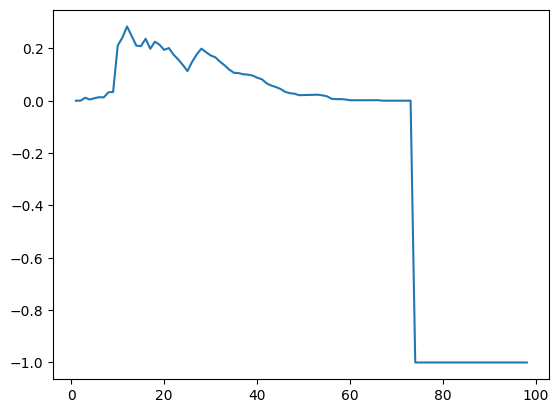

In [43]:
plt.plot(data.keys(), data.values())

In [41]:
rej_pred = benchmark.predict_proba(X_rej)[:,1]
acc_pred = benchmark.predict_proba(X_test)[:,1]

In [36]:
def evaluate_best_it(dsets, X_val_acp, y_val_acp, X_val_rej, AR, w):
    values = []

    for it in list(dsets.keys()):
        auc_value = roc_auc_score(y_val_acp, dsets[it].predict_proba(X_val_acp)[:,1])
        kick_value = ri.calculate_kickout_metric(dsets['BM'], dsets[it], X_val_acp, y_val_acp, X_val_rej, acp_rate=AR)[0]
        it_values = [auc_value, kick_value]
        values.append(it_values)
    weights = w
    values = np.array(values)
    
    criterias = np.array([True, True])
    t = top.Topsis(values, weights, criterias)
    t.calc()
    output = t.rank_to_best_similarity()[0] - 1
    print(f'best iteration: {output}')
    return output

In [37]:
# Initialize a dictionary to store metrics for each AR
metrics_data = {'AR': [], 'Kickout': [], 'KG': [], 'KB': []}

for ar in range(5, 96):
    AR = ar / 100
    # Assuming get_metrics_RI returns a DataFrame or similar structure with the required metrics
    df_met = ri.get_metrics_RI(models_dict, X_test, y_test, X_unl=X_rej, acp_rate=AR)
    filepath_ex = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
    
    datasets_ex = joblib.load(filepath_ex)

    output_ex = evaluate_best_it(datasets_ex, X_val, y_val, X_rej, AR, [1,1])
    
    if output_ex != 0:
        models_dict.update({'TN': datasets_ex[f'TN_{output_ex}']})
    else:
        models_dict.update({'TN': datasets_ex['BM']})

    # Collect metrics
    metrics_data['AR'].append(AR)
    metrics_data['Kickout'].append(df_met.loc['Kickout', 'TN'])
    metrics_data['KG'].append(df_met.loc['KG', 'TN'])
    metrics_data['KB'].append(df_met.loc['KB', 'TN'])

# Convert collected data into a DataFrame
metrics_df = pd.DataFrame(metrics_data)
metrics_df

best iteration: 5
best iteration: 6
best iteration: 6
best iteration: 6
best iteration: 6
best iteration: 6
best iteration: 6
best iteration: 1
best iteration: 6
best iteration: 6
best iteration: 6
best iteration: 6
best iteration: 6
best iteration: 6
best iteration: 6
best iteration: 6
best iteration: 9
best iteration: 6
best iteration: 6
best iteration: 8
best iteration: 8
best iteration: 8
best iteration: 8
best iteration: 8
best iteration: 8
best iteration: 8
best iteration: 37
best iteration: 37
best iteration: 37
best iteration: 37
best iteration: 37
best iteration: 21
best iteration: 22
best iteration: 22
best iteration: 22
best iteration: 22
best iteration: 22
best iteration: 22
best iteration: 22
best iteration: 24
best iteration: 24
best iteration: 19
best iteration: 19
best iteration: 20
best iteration: 20
best iteration: 20
best iteration: 20
best iteration: 20
best iteration: 20
best iteration: 20
best iteration: 20
best iteration: 20
best iteration: 20
best iteration: 20


,AR,Kickout,KG,KB
0,0.05,0.000000,0.0,0.0
1,0.06,0.679130,364.0,126.0
2,0.07,0.667578,371.0,112.0
3,0.08,0.665531,378.0,105.0
4,0.09,0.664488,372.0,98.0
...,...,...,...,...
86,0.91,0.000000,0.0,0.0
87,0.92,0.000000,0.0,0.0
88,0.93,0.000000,0.0,0.0
89,0.94,0.000000,0.0,0.0


In [38]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# Select the columns to be normalized
columns_to_normalize = ['KG', 'KB']
# Fit the scaler to your data and transform it
metrics_df[columns_to_normalize] = scaler.fit_transform(metrics_df[columns_to_normalize])

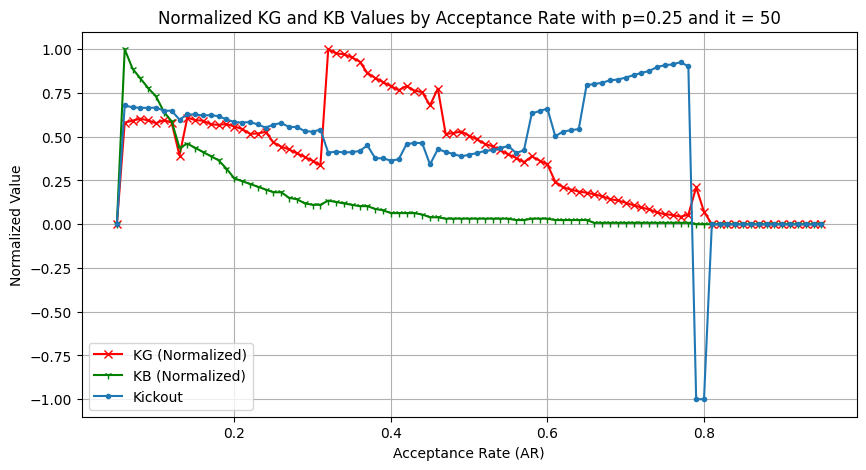

In [39]:
import matplotlib.pyplot as plt

# Plot KG x KB values
plt.figure(figsize=(10, 5))
# Plotting the normalized KG values
plt.plot(metrics_df['AR'], metrics_df['KG'], label='KG (Normalized)', color='red', marker='x')

# Plotting the normalized KB values
plt.plot(metrics_df['AR'], metrics_df['KB'], label='KB (Normalized)', color='green', marker='1')

# Plotting the Kickout values
plt.plot(metrics_df['AR'], metrics_df['Kickout'], label='Kickout', marker='.')

# Adding plot titles and labels
plt.title(f'Normalized KG and KB Values by Acceptance Rate with p={p} and it = {it}')
plt.xlabel('Acceptance Rate (AR)')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)

plt.savefig(f'{backup_image_folder}kickout-KG-KB_by_AR-{seed_number}-{p}-{it}.png',  dpi=150)

plt.show()

#<font color='red'>Definition of Train and Test Val, and Unl</font>

In [58]:
N_splits=5  
kf = KFold(n_splits=N_splits)   #80-20 split for train-test
hist_dict = {}

for fold_number, (train_index, test_index) in enumerate(kf.split(df_a)):
    #diferent seed for each iteration
    seed_number = main_seed+fold_number

    df_train = df_a.iloc[train_index]
    df_test = df_a.iloc[test_index]
    
    val_split = int(df_train.shape[0] * 0.2)  #80-20 split for train-validation
    df_val = df_train.iloc[:val_split]
    df_train = df_train.iloc[val_split:]

    # df_train, policy_model = ri.fit_policy(df_train)

    X_train = df_train.loc[:, df_train.columns != "target"]
    X_test = df_test.loc[:, df_test.columns != "target"]
    X_val = df_val.loc[:, df_val.columns != "target"]
    y_train, y_test, y_val = df_train["target"], df_test["target"], df_val["target"]

    X_train_acp, y_train_acp = X_train, y_train
    X_test_acp, y_test_acp = X_test, y_test
    X_val_acp, y_val_acp = X_val, y_val
    
    # dex.get_shapes(X_train_acp, X_train_rej, X_test_acp, X_test_rej, X_val_acp, X_val_rej)

    # metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    # break
    models_dict = {}

    benchmark = tr.create_pipeline(X_train_acp, y_train_acp,
                                  LGBMClassifier(**params_dict['LightGBM_2']), do_EBE=True)
    benchmark.fit(X_train_acp, y_train_acp)

    X_train_transformed = benchmark[:-3].transform(X_train)
    df_rej_knn = knn_inputer(X_train_transformed, df_r, 2)

    X_train_rej, X_test_rej = train_test_split(df_rej_knn, test_size=0.2, random_state=seed_number)
    X_train_rej, X_val_rej = train_test_split(X_train_rej, test_size=0.3, random_state=seed_number)
    
    models_dict['BM'] = benchmark

    models_dict.update(
        ri.augmentation_with_soft_cutoff(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='up', seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='down', seed = seed_number))
    # models_dict.update(
    #     ri.fuzzy_augmentation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.extrapolation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.parcelling(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.label_spreading(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.trusted_non_outliers(X_train_acp, y_train_acp, X_train_rej,
    #                              X_val_acp, y_val_acp, iterations=10,p=0.18, seed=seed_number))
    
    hist_dict[fold_number] = ri.get_metrics_RI(models_dict, X_test_acp, 
                                               y_test_acp, X_unl=X_test_rej, acp_rate=0.5)
    print(f'fold_number: {fold_number}')
    # break

fold_number: 0
fold_number: 1
fold_number: 2
fold_number: 3
fold_number: 4


In [60]:
mean_metrics = sum([hist_dict[i] for i in range(N_splits)])/N_splits
mean_metrics

,BM,A-SC,A-UW,A-DW
Overall AUC,0.937626,0.936765,0.937789,0.912575
KS,0.749531,0.744460,0.744607,0.692028
Balanced Accuracy,0.874766,0.872230,0.872304,0.846014
Accuracy,0.869145,0.869906,0.872553,0.844339
Precision,0.516230,0.516529,0.525279,0.474104
Recall,0.882081,0.876007,0.872493,0.848706
F1,0.648347,0.649649,0.654922,0.605236
Kickout,0.000000,-0.000764,-0.000383,-0.019893
KG,0.000000,0.400000,0.200000,10.400000
KB,0.000000,0.000000,0.000000,0.000000


In [ ]:
metric = hist_dict[0].loc[['Overall AUC','KS','Kickout']]

In [ ]:
metric.plot.bar()

In [ ]:
metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=0.01)

In [ ]:
#@title Show evolution of metrics

metrics_df = metrics.copy()#_techniques.copy()

# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot =  ['Overall AUC', 'Balanced Accuracy', 'Accuracy', 'Approval Rate']
cols_plotted = []

# Iterate over the columns of metrics_df.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

In [ ]:
#@title Show evolution of metrics
# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot = ['KS','Precision', 'Recall','F1', 'Kickout']
cols_plotted = []

# Iterate over the columns of metrics.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()